# Big Project (Homework Assignemnt- 03)

## Lazy FCA (Formal Concept Analysis) Classifcation.

### Import libraries

In [1]:
# Import necessary libraries for data processing, visualization, and machine learning
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced data visualization (statistical plots)
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.model_selection import train_test_split  # For splitting the data into training and testing sets

### Load the dataset

In [2]:
# Load the dataset
df = pd.read_csv('heart_disease_uci.csv')  # Load the heart disease dataset into a DataFrame
df.head()  # Display the first few rows of the dataset to get an overview

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## Exploratory Data Analysis

### Display basic information of dataset

In [ ]:
# Display basic information about the dataset (e.g., column types, non-null values)
print("Dataset Information:")
print(df.info())

#### Dataset Information

The dataset contains **920 entries** with **16 columns**. Each column represents a specific feature related to heart disease diagnosis. Below is a detailed description of the dataset:

#### General Information
- **Number of Rows**: 920
- **Number of Columns**: 16
- **Missing Values**: Several columns (e.g., `trestbps`, `chol`, `slope`, `ca`, `thal`) have missing values, which may need imputation or handling during preprocessing.
- **Data Types**: The dataset includes:
  - `float64` (5 columns): Continuous numerical features.
  - `int64` (3 columns): Integer features, including identifiers and the target variable.
  - `object` (8 columns): Categorical features such as gender, chest pain type, and thalassemia status.


### Display basic statistics of categorical features

In [4]:
# Display basic statistics for numeric columns (e.g., mean, min, max, etc.)
print("\nBasic Statistical Description:")
print(df.describe())


Basic Statistical Description:
               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.995652  
std      0.935653    1.142693  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000

In [5]:
# Drop irrelevant columns (e.g., 'id' column, if it's not needed for the analysis)
df = df.drop(columns=['id'])

### Feature correlation analysis

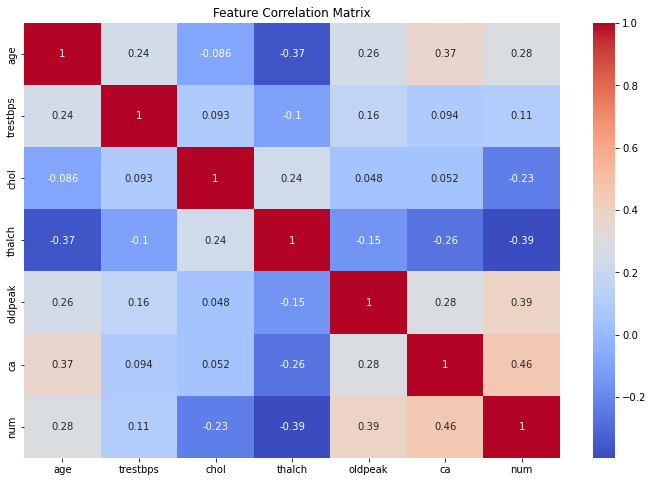

In [7]:
# Feature correlation analysis - Compute the correlation matrix for all features
correlation_matrix = df.corr()  # Calculate pairwise correlation of features
plt.figure(figsize=(12, 8))  # Set the figure size for the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # Visualize correlation matrix using heatmap
plt.title("Feature Correlation Matrix")  # Set title for the plot
plt.show()  # Display the plot

### Analysis from this correlation plot
From this correlation plot a significant correlation exists between "num" (heart disease diagnosis) and "ca" (number of major vessels) and "oldpeak" (ST depression caused by exercise), suggesting an association between increased values in these features and a higher risk of heart disease.  Conversely, "num" exhibits a negative correlation with "thalch" (maximum heart rate achieved), indicating that individuals with higher exercise capacity may have a lower risk of heart disease. 

### Relationship between features and the target variable

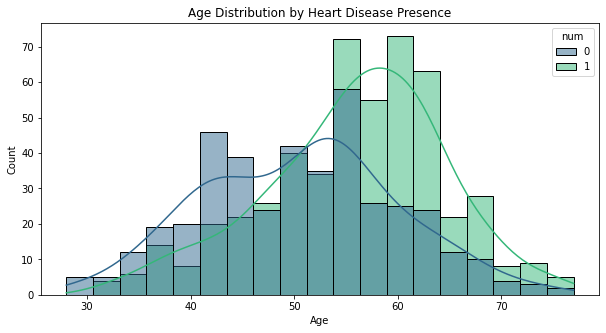

In [8]:
# Visualize the relationship between features and the target variable 'num'
# Plotting the distribution of age based on heart disease presence
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='age', hue='num', kde=True, palette='viridis')  # Plot age distribution with heart disease classes
plt.title("Age Distribution by Heart Disease Presence")  # Set plot title
plt.xlabel("Age")  # Label the x-axis
plt.ylabel("Count")  # Label the y-axis
plt.show()  # Display the plot

### Distribution analysis of heart disease based on age

In the plot, there is a clear association between age and the presence of heart disease. As age increases, the likelihood of heart disease also increases. Individuals without heart disease are more evenly distributed across the age range, while those with heart disease tend to live longer. Accordingly, heart disease risk increases with age. 

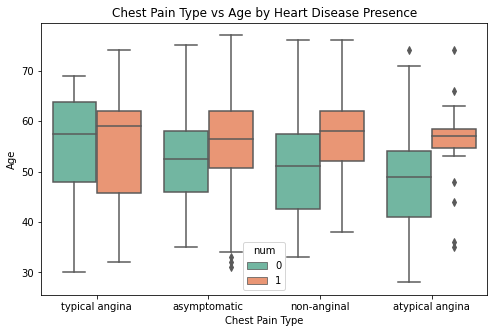

In [9]:
# Box plot to examine the relationship between chest pain type ('cp') and age, with respect to heart disease presence
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cp', y='age', hue='num', palette='Set2')  # Box plot for chest pain type vs age
plt.title("Chest Pain Type vs Age by Heart Disease Presence")  # Set plot title
plt.xlabel("Chest Pain Type")  # Label the x-axis
plt.ylabel("Age")  # Label the y-axis
plt.show()  # Display the plot

### Box plot analysis of the relationship between (Chest pain) vs (Age), vs (Heart Disease)

The graph shows that people with chest pain, especially typical angina, tend to be older, whether they have heart disease or not. It also shows that older people are more likely to have heart disease, regardless of their chest pain type. This suggests that age is a major factor in heart disease, especially when combined with certain types of chest pain.

In [10]:
# Check for missing values in the features (X)
print("\nMissing Values Count:")
print(df.isnull().sum())


Missing Values Count:
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


### Missing Values

Some values are missing, like blood pressure, cholesterol levels, and heart rate measurements. We need to fix this before we can fully analyze the data and draw reliable conclusions about heart disease.

### Identify categorical and continuous features in the dataset

In [11]:
# Identify categorical and continuous features in the dataset
categorical_features = df.select_dtypes(include=['object']).columns  # Categorical features are of type 'object'
continuous_features = df.select_dtypes(include=['number']).columns  # Continuous features are of numeric type

In [12]:
# Display value counts for each categorical feature (to understand the distribution of categories)
for col in categorical_features:
    print(f"Value counts for {col}:\n{df[col].value_counts()}\n")

Value counts for sex:
Male      726
Female    194
Name: sex, dtype: int64

Value counts for dataset:
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: dataset, dtype: int64

Value counts for cp:
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: cp, dtype: int64

Value counts for fbs:
False    692
True     138
Name: fbs, dtype: int64

Value counts for restecg:
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: restecg, dtype: int64

Value counts for exang:
False    528
True     337
Name: exang, dtype: int64

Value counts for slope:
flat           345
upsloping      203
downsloping     63
Name: slope, dtype: int64

Value counts for thal:
normal               196
reversable defect    192
fixed defect          46
Name: thal, dtype: int64



### Handling missing values

In [13]:
# Handle missing data
# For categorical features, use the most frequent value to fill missing data
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

In [14]:
# For continuous features, use the mean value to fill missing data
cont_imputer = SimpleImputer(strategy='mean')
df[continuous_features] = cont_imputer.fit_transform(df[continuous_features])

# Confirm that missing values have been imputed
print("Missing values after imputation: ")
df.isnull().sum()

Missing values after imputation: 


age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

## Feature Binarization for Heart Disease Prediction Dataset

### Initialize an empty DataFrame

In [15]:
# Initialize an empty DataFrame to store the binarized features
df_binarized = pd.DataFrame(index=df.index)

### 1. Age (age)

**Binarization:**
- **Thresholds:** `<40, 40-60, 60-80, ≥80`.
- **Categories:**
  - `age_le_40`: Age ≤ 40.
  - `age_40_to_60`: Age in (40, 60].
  - `age_60_to_80`: Age in (60, 80].
  - `age_ge_80`: Age ≥ 80.

**Reason:**  
These thresholds correspond to common groupings used in medical studies to analyze age-related health risks (e.g., young adults, middle-aged, elderly).

In [16]:
# 1. Binarizing 'age' with thresholds
min_age = df['age'].min()
max_age = df['age'].max()
age_thresholds = [min_age, 20, 40, 60, max_age]
for threshold in age_thresholds:
    df_binarized[f'age_le_{threshold}'] = df['age'] <= threshold
    df_binarized[f'age_ge_{threshold}'] = df['age'] >= threshold

### 2. Sex (sex)

**Binarization:**
- `male`: Sex = 1 (male).
- `female`: Sex = 0 (female).

**Reason:**  
This binary feature directly represents male or female. No additional binarization was necessary.

In [17]:
# 2. Binarizing 'sex' (1 for male, 0 for female)
df_binarized['sex_male'] = df['sex'] == 'male'
df_binarized['sex_female'] = df['sex'] == 'female'

### 3. Dataset Identifier (dataset)

**Binarization:**
- `dataset_x`: Binary flags for each dataset (e.g., Dataset 1, 2, etc.).
- Cleveland       
- Hungary          
- VA Long Beach    
- Switzerland     

**Reason:**  
The dataset field likely indicates the source of the data or study groups. Binarizing it allows separating and comparing different subsets of the dataset.


In [18]:
# 3. Binarizing 'dataset' feature (Dataset Identifier Type)
df_binarized['data_Cleveland'] = df['dataset'] == 'Cleveland'
df_binarized['data_Hungary'] = df['dataset'] == 'Hungary'
df_binarized['data_VA_Long_Beach'] = df['dataset'] == 'VA Long Beach'
df_binarized['data_Switzerland'] = df['dataset'] == 'Switzerland'

### 4. Chest Pain Type (cp)

**Binarization:**
- `cp_1`: Typical angina.
- `cp_2`: Atypical angina.
- `cp_3`: Non-anginal pain.
- `cp_4`: Asymptomatic.

**Reason:**  
Chest pain types are categorical with ordinal levels, so binary indicators for each category are appropriate to allow the classifier to distinguish specific types.

In [19]:
# 4. Binarizing 'cp' (Chest Pain Type)
df_binarized['cp_typical_angina'] = df['cp'] == 'typical angina'
df_binarized['cp_atypical_angina'] = df['cp'] == 'atypical angina'
df_binarized['cp_non_anginal'] = df['cp'] == 'non-anginal'
df_binarized['cp_asymptomatic'] = df['cp'] == 'asymptomatic'



## 5. Resting Blood Pressure (trestbps)

**Binarization:**
- **Thresholds:** `<120, 120-139, 140-159, ≥160`.
- **Categories:**
  - `trestbps_le_120`: BP ≤ 120.
  - `trestbps_120_to_139`: BP in (120, 139].
  - `trestbps_140_to_159`: BP in (140, 159].
  - `trestbps_ge_160`: BP ≥ 160.

**Reason:**  
These thresholds align with hypertension stages (normal, pre-hypertension, hypertension stages 1 and 2).

In [20]:
# 5. Binarizing 'trestbps' (Resting Blood Pressure)
min_trestbps = df['trestbps'].min()
max_trestbps = df['trestbps'].max()
trestbps_thresholds = [min_trestbps, 120, 140, 160, max_trestbps]
for threshold in trestbps_thresholds:
    df_binarized[f'trestbps_le_{threshold}'] = df['trestbps'] <= threshold
    df_binarized[f'trestbps_ge_{threshold}'] = df['trestbps'] >= threshold

## 6. Cholesterol (chol)

**Binarization:**
- **Thresholds:** `<200, 200-239, ≥240`.
- **Categories:**
  - `chol_le_200`: Cholesterol ≤ 200 (desirable).
  - `chol_200_to_239`: Cholesterol in (200, 239] (borderline high).
  - `chol_ge_240`: Cholesterol ≥ 240 (high).

**Reason:**  
These thresholds are clinically defined ranges for cholesterol levels.

In [21]:
# 6. Binarizing 'chol' (Serum Cholesterol)
min_chol = df['chol'].min()
max_chol = df['chol'].max()
chol_thresholds = [min_chol, 200, 240, 280, max_chol]
for threshold in chol_thresholds:
    df_binarized[f'chol_le_{threshold}'] = df['chol'] <= threshold
    df_binarized[f'chol_ge_{threshold}'] = df['chol'] >= threshold

### 7. Fasting Blood Sugar (fbs)

**Binarization:**
- `fbs_high`: FBS > 120.
- `fbs_normal`: FBS ≤ 120.

**Reason:**  
The clinical cutoff of 120 mg/dL separates normal and abnormal fasting blood sugar levels.

In [22]:
# 7. Binarizing 'fbs' (Fasting Blood Sugar)
df_binarized['fbs'] = df['fbs'] == 1

### 8. Resting Electrocardiographic Results (restecg)

**Binarization:**
- `restecg_0`: Normal ECG.
- `restecg_1`: ST-T wave abnormality.
- `restecg_2`: Probable or definite left ventricular hypertrophy.

**Reason:**  
The ordinal nature of `restecg` justifies binary flags for each ECG state.


In [23]:
# 8. Binarizing 'restecg' (Resting ECG results)
df_binarized['restecg_normal'] = df['restecg'] == 'normal'
df_binarized['restecg_stt_abnormality'] = df['restecg'] == 'stt abnormality'
df_binarized['restecg_lv_hypertrophy'] = df['restecg'] == 'lv hypertrophy'

### 9. Maximum Heart Rate Achieved (thalch)

**Binarization:**
- **Thresholds:** `<100, 100-140, 140-180, ≥180`.
- **Categories:**
  - `thalch_le_100`: Heart rate ≤ 100.
  - `thalch_100_to_140`: Heart rate in (100, 140].
  - `thalch_140_to_180`: Heart rate in (140, 180].
  - `thalch_ge_180`: Heart rate ≥ 180.

**Reason:**  
These ranges help capture heart performance under stress and correlate with health risks.

In [24]:
# 9. Binarizing 'thalach' (Maximum Heart Rate Achieved)
min_thalach = df['thalch'].min()
max_thalach = df['thalch'].max()
thalach_thresholds = [min_thalach, 100, 140, 180, max_thalach]
for threshold in thalach_thresholds:
    df_binarized[f'thalch_le_{threshold}'] = df['thalch'] <= threshold
    df_binarized[f'thalch_ge_{threshold}'] = df['thalch'] >= threshold

### 10. Exercise-Induced Angina (exang)

**Binarization:**
- `exang_yes`: Angina during exercise (1).
- `exang_no`: No angina during exercise (0).

**Reason:**  
Exercise-induced angina is a binary indicator.


In [25]:
# 10. Binarizing 'exang' (Exercise Induced Angina)
df_binarized['exang'] = df['exang'] == 1

### 11. ST Depression Induced by Exercise (oldpeak)

**Binarization:**
- **Thresholds:** `<1, 1-2, ≥2`.
- **Categories:**
  - `oldpeak_le_1`: Depression ≤ 1.
  - `oldpeak_1_to_2`: Depression in (1, 2].
  - `oldpeak_ge_2`: Depression ≥ 2.

**Reason:**  
These thresholds reflect different levels of risk associated with ST depression.

In [26]:
# 11. Binarizing 'oldpeak' (ST Depression Induced by Exercise)
min_oldpeak = df['oldpeak'].min()
max_oldpeak = df['oldpeak'].max()
oldpeak_thresholds = [min_oldpeak, 1, 2, 3, max_oldpeak]
for threshold in oldpeak_thresholds:
    df_binarized[f'oldpeak_le_{threshold}'] = df['oldpeak'] <= threshold
    df_binarized[f'oldpeak_ge_{threshold}'] = df['oldpeak'] >= threshold

### 12. Slope of the Peak Exercise ST Segment (slope)

**Binarization:**
- `slope_1`: Upsloping.
- `slope_2`: Flat.
- `slope_3`: Downsloping.

**Reason:**  
The slope has categorical values indicating different cardiac conditions.

In [27]:
# 12. Binarizing 'slope' of the Peak Exercise ST Segment
df_binarized['slope_flat'] = df['slope'] == 'flat'
df_binarized['slope_upsloping'] = df['slope'] == 'upsloping'
df_binarized['slope_downsloping'] = df['slope'] == 'downsloping'

### 13. Number of Major Vessels Colored by Fluoroscopy (ca)

**Binarization:**
- **Categories for each value:**
  - `ca_0`: No major vessels.
  - `ca_1`: 1 major vessel.
  - `ca_2`: 2 major vessels.
  - `ca_3`: 3 major vessels.

**Reason:**  
The number of vessels ranges from 0 to 3, making it suitable for binary flags for each count.

In [28]:
# 13. Binarizing 'ca' (Number of Major Vessels)
for i in range(4):  # Assuming 'ca' ranges from 0 to 3
    df_binarized[f'ca_{i}'] = df['ca'] == i

### 14. Thalassemia Status (thal)

**Binarization:**
- `thal_normal`: Normal.
- `thal_fixed_defect`: Fixed defect.
- `thal_reversible_defect`: Reversible defect.

**Reason:**  
The `thal` feature is ordinal and corresponds to different medical conditions, so binary indicators for each state were used.



In [29]:
# 14. Binarizing 'thal' (Thalassemia)
df_binarized['thal_normal'] = df['thal'] == 'normal'
df_binarized['thal_fixed_defect'] = df['thal'] == 'fixed defect'
df_binarized['thal_reversible_defect'] = df['thal'] == 'reversible defect'

### 15. Target Variable: Presence of Heart Disease (num)

**Binarization:**
- `num_1`: Heart disease present (1).
- `num_0`: No heart disease (0).

**Reason:**  
The target variable is binary, indicating the presence or absence of heart disease.

In [30]:
# 15. Convert the target variable ('num') to a binary format (1 for presence, 0 for absence of heart disease)
df_binarized['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [34]:
# Convert True/False to 1/0
df_binarized = df_binarized.applymap(lambda x: 1 if x is True else (0 if x is False else x))

In [35]:
# Display the binarized data
df_binarized.head()

,age_le_28.0,age_ge_28.0,age_le_20,age_ge_20,age_le_40,age_ge_40,age_le_60,age_ge_60,age_le_77.0,age_ge_77.0,...,slope_upsloping,slope_downsloping,ca_0,ca_1,ca_2,ca_3,thal_normal,thal_fixed_defect,thal_reversible_defect,num
0,0,1,0,1,0,1,0,1,1,0,...,0,1,1,0,0,0,0,1,0,0
1,0,1,0,1,0,1,0,1,1,0,...,0,0,0,0,0,1,1,0,0,1
2,0,1,0,1,0,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,1,0,1,1,0,1,0,1,0,...,0,1,1,0,0,0,1,0,0,0
4,0,1,0,1,0,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0


In [36]:
# Display shape of the binarized data
df_binarized.shape

(920, 76)

In [ ]:
from typing import List, Any
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### Separate the features and target variables

In [41]:
# Separate the features (X) and target (y) variables for model training
X = df.drop(columns='num')  # Drop the target variable 'num' from the features
y = df['num']  # Target variable 'num' (presence of heart disease)

In [47]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)  # Display the shape of the training feature set
print(y_train.shape)  # Display the shape of the training target set
print(X_test.shape)   # Display the shape of the test feature set
print(y_test.shape)   # Display the shape of the test target set

(736, 15)
(736,)
(184, 15)
(184,)


In [37]:
# Implement Lazy FCA Classifier
class LazyFCAClassifier:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
    def _get_intersection(self, sample: pd.Series, other_sample: pd.Series) -> pd.Series:
        """Compute intersection between two samples."""
        return sample & other_sample

    def classify_sample(self, sample: pd.Series) -> Any:
        # Split X_train into positive and negative class groups
        X_pos = self.X_train[self.y_train == 1]
        X_neg = self.X_train[self.y_train == 0]

        pos_count = 0
        neg_count = 0

        # Define classifier functions to identify positive and negative classifiers
        def is_positive_classifier(intersection):
            return ((X_pos | ~intersection) == True).all(axis=1).sum() > 1 and \
                   ((X_neg | ~intersection) == True).all(axis=1).sum() == 0

        def is_negative_classifier(intersection):
            return ((X_neg | ~intersection) == True).all(axis=1).sum() > 1 and \
                   ((X_pos | ~intersection) == True).all(axis=1).sum() == 0

        # Check positive classifiers by intersecting with each positive sample
        for _, pos_sample in X_pos.iterrows():
            intersection = self._get_intersection(sample, pos_sample)
            if is_positive_classifier(intersection):
                pos_count += 1

        # Check negative classifiers by intersecting with each negative sample
        for _, neg_sample in X_neg.iterrows():
            intersection = self._get_intersection(sample, neg_sample)
            if is_negative_classifier(intersection):
                neg_count += 1

        # Decision based on counts
        if pos_count > neg_count:
            return 1
        elif neg_count > pos_count:
            return 0
        else:
            return 1  # Default to positive if there's a tie

    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        predictions = [self.classify_sample(row) for _, row in X_test.iterrows()]
        return predictions

In [38]:
# Instantiate and train Lazy FCA Classifier
lazy_fca = LazyFCAClassifier()
lazy_fca.fit(X_binarized.loc[X_train.index], y_train)

# Step 6: Calculate metrics for Lazy FCA Classifier
y_pred_lazy_fca = lazy_fca.predict(X_binarized.loc[X_test.index])
print("Lazy FCA Classifier Performance:")
print(classification_report(y_test, y_pred_lazy_fca))

Lazy FCA Classifier Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        82
           1       0.83      0.90      0.86       102

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [43]:
# Step 7: Compare with other classifiers
classifiers = {
    "K Nearest Neighbor": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

for name, clf in classifiers.items():
    clf.fit(X_binarized.loc[X_train.index], y_train)
    y_pred = clf.predict(X_binarized.loc[X_test.index])
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))


K Nearest Neighbor Performance:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        82
           1       0.85      0.85      0.85       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184


Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67        82
           1       0.88      0.28      0.43       102

    accuracy                           0.58       184
   macro avg       0.70      0.62      0.55       184
weighted avg       0.72      0.58      0.54       184


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        82
           1       0.84      0.86      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83  

C:\Users\hp\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\hp\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        82
           1       0.86      0.84      0.85       102

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



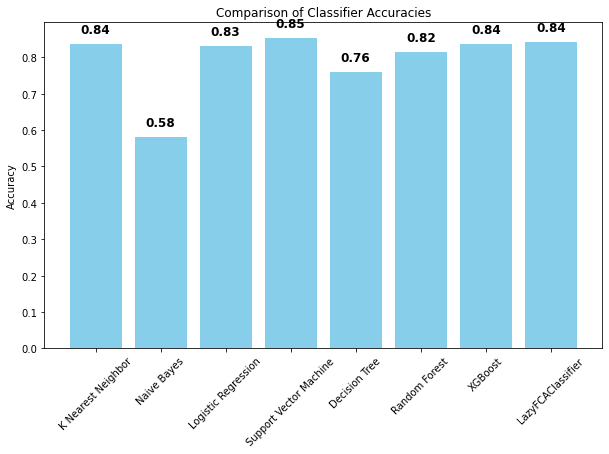

In [47]:
# Visual comparison of accuracy for each classifier
accuracies = [accuracy_score(y_test, clf.predict(X_binarized.loc[X_test.index])) for clf in classifiers.values()]
classifier_names = list(classifiers.keys())

# Predict and calculate accuracy for LazyFCAClassifier
lazy_fca_accuracy = accuracy_score(y_test, y_pred_lazy_fca)

# Append LazyFCAClassifier accuracy and name to lists
accuracies.append(lazy_fca_accuracy)
classifier_names.append("LazyFCAClassifier")

# Plot the accuracies for all classifiers including LazyFCAClassifier
plt.figure(figsize=(10, 6))
bars = plt.bar(classifier_names, accuracies, color='#87CEEB')  # Light Blue color for bars

# Display accuracy score on top of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f'{accuracy:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.show()